# DATA VISUALIZATION
Notebook que contiene el proceso de análisis exploratorio de los datos, en él se observara la correlación entre distintas variables y la distribución de alquileres y devoluciones en relación con ciertos atributos.

### LIBRERIAS

In [57]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import operator
import seaborn as sn
import holidays
import calendar

from scipy.stats import gaussian_kde
from datetime import datetime, timedelta, date
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### CARGA DE DATOS

In [58]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf.csv')

In [134]:
completeRentalsDf = pd.read_csv('../data/completeData/rentals/completeRentalsDf_LOG1P.csv')
completeReturnsDf = pd.read_csv('../data/completeData/returns/completeReturnsDf_LOG1P.csv')

In [59]:
completeRentalsDf['Date'] = pd.to_datetime(completeRentalsDf['Date'])
completeReturnsDf['Date'] = pd.to_datetime(completeReturnsDf['Date'])

completeRentalsDf.set_index('Date', inplace=True)
completeReturnsDf.set_index('Date', inplace=True)

In [60]:
weatherDf = pd.read_csv('../data/completeData/weather/completeWeatherDf.csv')
weatherDf.drop(columns=['Date'], inplace=True)

In [61]:
print("completeRentals DF tiene {} filas y {} columnas".format(completeRentalsDf.shape[0], completeRentalsDf.shape[1]))
print("completeReturns DF tiene {} filas y {} columnas".format(completeReturnsDf.shape[0], completeReturnsDf.shape[1]))
print("weather DF tiene {} filas y {} columnas".format(weatherDf.shape[0], weatherDf.shape[1]))

completeRentals DF tiene 101064 filas y 694 columnas
completeReturns DF tiene 101064 filas y 694 columnas
weather DF tiene 101064 filas y 22 columnas


## DESCOMPOSICIÓN ESTACIONAL
La descomposición de series temporales es una técnica que separa las series temporales en múltiples componentes, representando un patrón de categoría, tendencia, estacionalidad y ruido.

### ALQUILERES

In [ ]:
plt.rcParams["figure.figsize"] = (20,14)

In [ ]:
# Periodo diario
additive_decomposition_rentals = seasonal_decompose(completeRentalsDf['31201'], model='additive', period=24)
additive_decomposition_rentals.plot().suptitle('Additive Decomposition Rentals', fontsize=14)

In [ ]:
# Periodo semanal
additive_decomposition_rentals = seasonal_decompose(completeRentalsDf['31201'], model='additive', period=168)
additive_decomposition_rentals.plot().suptitle('Additive Decomposition Rentals', fontsize=14)

In [ ]:
# Periodo mensual
additive_decomposition_rentals = seasonal_decompose(completeRentalsDf['31201'], model='additive', period=672)
additive_decomposition_rentals.plot().suptitle('Additive Decomposition Rentals', fontsize=18)

In [ ]:
# Periodo anual
additive_decomposition_rentals = seasonal_decompose(completeRentalsDf['31201'], model='additive', period=8760)
additive_decomposition_rentals.plot().suptitle('Additive Decomposition Rentals', fontsize=14)

### DEVOLUCIONES
Comprobamos que el aspecto de la descomposición de las devoluciones sea similar.

In [ ]:
# Periodo mensual
additive_decomposition_rentals = seasonal_decompose(completeReturnsDf['31201'], model='additive', period=672)
additive_decomposition_rentals.plot().suptitle('Additive Decomposition Returns', fontsize=14)

## AUTOCORRELACIÓN Y AUTOCORRELACIÓN PARCIAL
Es de interés observar cuáles son los lags con los que la serie temporal de cada estación se relaciona más consigo misma.

### ALQUILERES

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,12))
plot_acf(completeRentalsDf['31201'], lags =672, ax = ax1)
plot_pacf(completeRentalsDf['31201'], lags =672, ax = ax2)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,12))
plot_acf(completeRentalsDf['31201'], lags =170, ax = ax1)
plot_pacf(completeRentalsDf['31201'], lags =170, ax = ax2)
plt.show()

Al parecer, los lags mútiplos de 24 generan picos de auto correlación parcial. Cabe destacar que para el modelo predictivo de un día completo, no se contara con los datos de las primeras 23 horas, por lo que estas se descartan del análisis.

### DEVOLUCIONES

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,12))
plot_acf(completeReturnsDf['31201'], lags =170, ax = ax1)
plot_pacf(completeReturnsDf['31201'], lags =170, ax = ax2)
plt.show()

Al parecer, esta correlación también se mantiene en los datos de devoluciónes.

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (15,12))
plot_acf(completeReturnsDf['31105'], lags =170, ax = ax1)
plot_pacf(completeReturnsDf['31105'], lags =170, ax = ax2)
plt.show()

... y en los datos de otras estaciones.

## AGREGAR DATOS HISTÓRICOS PREVIOS
Para el análisis de los datos existentes, se van a agregar ciertos datos históricos previos derivados de los mismos.

#### DATOS DE ALQUILERES Y DEVOLUCIONES

In [ ]:
completeRentalsLaggedDf = completeRentalsDf.copy()
completeReturnsLaggedDf = completeReturnsDf.copy()

lags = [24, 48, 168]
for lag in lags:
    shiftedRentals = completeRentalsDf.shift(lag)
    shiftedRentals.columns = [columnName + "_lag" + str(lag) for columnName in completeRentalsDf.columns]
    completeRentalsLaggedDf = pd.concat((completeRentalsLaggedDf, shiftedRentals), axis=1)

    shiftedReturns = completeReturnsDf.shift(lag)
    shiftedReturns.columns = [columnName + "_lag" + str(lag) for columnName in completeReturnsDf.columns]
    completeReturnsLaggedDf = pd.concat((completeReturnsLaggedDf, shiftedReturns), axis=1)

completeRentalsLaggedDf.dropna(inplace=True)
completeReturnsLaggedDf.dropna(inplace=True)

In [ ]:
print("El dataframe de alquileres con datos laggeados tiene {} filas y {} columnas".format(completeRentalsLaggedDf.shape[0], completeRentalsLaggedDf.shape[1]))
print("El dataframe de devoluciones con datos laggeados tiene {} filas y {} columnas".format(completeReturnsLaggedDf.shape[0], completeReturnsLaggedDf.shape[1]))

In [ ]:
dates = completeRentalsLaggedDf.index # Se almacenan las fechas para un uso posteriorr
completeRentalsDf = completeRentalsLaggedDf
completeReturnsDf = completeReturnsLaggedDf

Comprobamos que los lags se han generado correctamente.

In [ ]:
completeRentalsDf[['0', '0_lag24', '0_lag48', '0_lag168']].tail(49)

### DATOS METEOROLÓGICOS
Tras comprobar que la temperatura, humedad y la condición 'parcialmente nublado' son las variables meteorológicas que más correlación mantienen con los datos de alquileres y devoluciones, se hará uso de esos atributos y se añadirán lags de los mismos.

In [ ]:
weatherDf = weatherDf[['temp', 'humidity', 'conditions_Partially cloudy']]
weatherLaggedDf = weatherDf.copy()

lags = [1, 24, 48, 168]
for lag in lags:
    shiftedWeather = weatherDf.shift(lag)
    shiftedWeather.columns = [columnName + "_lag" + str(lag) for columnName in weatherDf.columns]
    weatherLaggedDf = pd.concat((weatherLaggedDf, shiftedWeather), axis=1)

weatherLaggedDf.dropna(inplace=True)
weatherLaggedDf['temp^2'] = weatherLaggedDf['temp']**2
weatherLaggedDf['temp^2_lag1'] = weatherLaggedDf['temp_lag1']**2
weatherLaggedDf['temp^2_lag24'] = weatherLaggedDf['temp_lag24']**2
weatherLaggedDf['temp^2_lag168'] = weatherLaggedDf['temp_lag168']**2
weatherDf = weatherLaggedDf

### DATOS RELACIONADOS CON LA FECHA
En último lugar, vamos a añadir ciertas características nuevas derivadas de la fecha, como puede ser la hora, día, festivo, etc. Se hace sobre weatherDf para solo tener que modificar un DataFrame.

In [ ]:
weekdays = { 0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
holidays_dc = holidays.US(state='DC')

In [ ]:
weatherDf['Hour'], weatherDf['Day'], weatherDf['Month'], weatherDf['Year'], weatherDf['Holiday'], weatherDf['After-Holiday'], weatherDf['System OOS'] = -1, -1, -1, -1, -1, -1, -1
weatherDf['Weekday'] = ""
weatherDf['Date'] = dates

In [ ]:
weatherDf.reset_index(inplace=True)
for i, row in enumerate(weatherDf.itertuples()):
    weatherDf.at[i, 'Hour'] = row.Date.hour
    weatherDf.at[i, 'Day'] = row.Date.day
    weatherDf.at[i, 'Month'] = row.Date.month
    weatherDf.at[i, 'Year'] = row.Date.year
    weatherDf.at[i, 'Weekday'] = weekdays.get(row.Date.weekday())
    weatherDf.at[i, 'Holiday'] = 1 if row.Date.date() in holidays_dc else 0
    weatherDf.at[i, 'After-Holiday'] = 1 if row.Date.date()- timedelta(days=1) in holidays_dc else 0
    weatherDf.at[i, 'System OOS'] = 1 if row.Date.date() >= date(2016, 1, 23) and row.Date.date() <= date(2016, 1, 26) else 0

weatherDf = pd.get_dummies(weatherDf, columns=['Weekday'])
weatherDf.set_index('Date', inplace=True)
weatherDf.drop('index', axis=1, inplace=True)

In [ ]:
weatherDf.tail(5)

## MATRIZ DE CORRELACIÓN
Como calcular una matriz de correlación para las 680 estaciones resulta computacionalmente costoso y lento, se observaran solo algunas de las estaciones.

In [ ]:
stations = []
for stationNumber in range(31200, 31205, 1):
    stations.append('%05i' % stationNumber)
    stations.append('%05i' % stationNumber + '_lag24')
    stations.append('%05i' % stationNumber + '_lag48')
    stations.append('%05i' % stationNumber + '_lag168')

completeRentalsDf = completeRentalsDf.loc[:, completeRentalsDf.columns.isin(stations)]
completeReturnsDf = completeReturnsDf.loc[:, completeReturnsDf.columns.isin(stations)]

In [ ]:
print("completeRentals DF tiene {} filas y {} columnas".format(completeRentalsDf.shape[0], completeRentalsDf.shape[1]))
print("completeReturns DF tiene {} filas y {} columnas".format(completeReturnsDf.shape[0], completeReturnsDf.shape[1]))
print("weather DF tiene {} filas y {} columnas".format(weatherDf.shape[0], weatherDf.shape[1]))

In [ ]:
completeRentalsDf = pd.concat([completeRentalsDf.reset_index(drop=True), weatherDf.reset_index(drop=True)], axis=1)
completeReturnsDf = pd.concat([completeReturnsDf.reset_index(drop=True), weatherDf.reset_index(drop=True)], axis=1)

In [ ]:
print("completeRentals DF tiene {} filas y {} columnas".format(completeRentalsDf.shape[0], completeRentalsDf.shape[1]))
print("completeReturns DF tiene {} filas y {} columnas".format(completeReturnsDf.shape[0], completeReturnsDf.shape[1]))

In [ ]:
completeRentalsDf['Date'] = dates
completeReturnsDf['Date'] = dates
completeRentalsDf.set_index('Date', inplace=True)
completeReturnsDf.set_index('Date', inplace=True)

In [ ]:
completeRentalsDf.tail(5)

### CORRELACIÓN ENTRE VARIABLES - ALQUILERES

In [ ]:
plt.rcParams["figure.figsize"] = (50,40)
corrMatrixRentals = completeRentalsDf.corr()
sn.heatmap(corrMatrixRentals, annot=True)
plt.show()

### CORRELACIÓN ENTRE VARIABLES - DEVOLUCIONES

In [ ]:
corrMatrixReturns = completeReturnsDf.corr()
sn.heatmap(corrMatrixReturns, annot=True)
plt.show()

## DISTRIBUCION DE LOS ALQUILERES Y DEVOLUCIONES RESPECTO A OTRAS VARIABLES

In [ ]:
completeRentalsDf['Date'] = dates
completeReturnsDf['Date'] = dates
weatherDf['Date'] = dates

In [ ]:
def scatterPlot(df, startDate, endDate, columns, colors, xColumn, yLabel):
    df['Date'] = pd.to_datetime(df['Date'])
    dfFiltered = df[ (df['Date'] >= startDate) & (df['Date'] < endDate) ]

    for i,column in enumerate(columns):
        if i==0:
            ax1 = dfFiltered.plot(kind='scatter', x=xColumn, y=column, color=colors[i], figsize=(30,10), label=column)
        else:
            ax = dfFiltered.plot(kind='scatter', x=xColumn, y=column, color=colors[i], ax=ax1, label=column)
        ax1.set_ylabel(yLabel)

def densityScatterPlot(x, y, cmap, xLabel, yLabel, title):
    plt.rcParams["figure.figsize"] = (15,5)
    xy = np.vstack([x, y])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots()
    plt.scatter(x, y, c=z, s=15,cmap = cmap)
    plt.xlabel(xLabel,size = 10)
    plt.ylabel(yLabel,size = 10)
    plt.title(title)
    cb = plt.colorbar()
    plt.show()

def groupedLinePlot(df, startDate, endDate, groupVariable, columns, yColumn, yLabel, title ):
    df['Date'] = pd.to_datetime(df['Date'])
    dfFiltered = df[ (df['Date'] >= startDate) & (df['Date'] < endDate) ]
    for i,column in enumerate(columns):
        dfFiltered2 = dfFiltered[dfFiltered[column]>0]
        dfGrouped = dfFiltered2.groupby([groupVariable]).mean()
        dfGrouped['Hour'] = dfGrouped.index.values
        if i==0:
            ax1 = dfGrouped.plot.line(x=groupVariable, y=yColumn, title=title)
        else:
            dfGrouped.plot.line(x=groupVariable, y=yColumn, ax=ax1)
    ax1.set_ylabel(yLabel)
    ax1.legend(columns)

def monthlyScatterPlot(df, startDate, endDate, station, column, months):
    df['Date'] = pd.to_datetime(df['Date'])
    dfFiltered = df[ (df['Date'] >= startDate) & (df['Date'] < endDate) ]

    fig, ax = plt.subplots(3, 4, sharey=True, figsize=(30,15))
    if column == 'Hour':
        xlim = [-1, 24]
    elif column == 'temp':
        xlim = [-20, 45]
    elif column == 'humidity':
        xlim = [0, 110]

    month=1
    for x in range(0,3,1):
        for y in range(0,4,1):
            dfFiltered2 = dfFiltered[dfFiltered['Month'] == month]
            ax[x,y].scatter(dfFiltered2[column], dfFiltered2[station])
            ax[x,y].set_xlim(xlim)
            ax[x,y].set_ylabel(station)
            ax[x,y].set_title(months[month-1])
            month+=1

def hourlyScatterPlot(df, startDate, endDate, station, column, hours):
    df['Date'] = pd.to_datetime(df['Date'])
    dfFiltered = df[ (df['Date'] >= startDate) & (df['Date'] < endDate) ]

    fig, ax = plt.subplots(4, 6, sharey=True, figsize=(30,15))
    if column == 'temp':
        xlim = [-20, 45]
    elif column == 'humidity':
        xlim = [0, 110]

    hour=0
    for x in range(0,4,1):
        for y in range(0,6,1):
            dfFiltered2 = dfFiltered[dfFiltered['Hour'] == hour]
            ax[x,y].scatter(dfFiltered2[column], dfFiltered2[station])
            ax[x,y].set_xlim(xlim)
            ax[x,y].set_ylabel(station)
            ax[x,y].set_title(hours[hour])
            hour+=1


In [ ]:
columns = ['31200','31201', '31202']
colors = ['r', 'b', 'g']
weekdays = ['Weekday_Monday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Weekday_Thursday', 'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday']
months = [x for x in calendar.month_name if x]
hours = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)

In [ ]:
groupedLinePlot(completeRentalsDf, datetime(2010,9,27), datetime(2022,4,1), 'Hour', weekdays, '31201', "Nº Rentals", "Rentals mean per weekday")

In [ ]:
groupedLinePlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), 'Hour', weekdays, '31201', "Nº Returns", "Returns mean per weekday")

In [ ]:
groupedLinePlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), 'Hour', weekdays, '31203', "Nº Returns", "Returns mean per weekday")

In [ ]:
groupedLinePlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), 'Hour', weekdays, '31204', "Nº Returns", "Returns mean per weekday")

In [ ]:
scatterPlot(completeRentalsDf, datetime(2018,1,1), datetime(2018,2,1), columns, colors, "Date", "Nº Rentals")

In [ ]:
scatterPlot(completeRentalsDf, datetime(2020,1,1), datetime(2020,2,1), columns, colors, "Date", "Nº Rentals")

In [ ]:
scatterPlot(completeRentalsDf, datetime(2022,1,1), datetime(2022,2,1), columns, colors, "Date", "Nº Rentals")

In [ ]:
scatterPlot(completeReturnsDf, datetime(2018,1,1), datetime(2018,2,1), columns, colors, "Date", "Nº Returns")

In [ ]:
scatterPlot(completeReturnsDf, datetime(2020,1,1), datetime(2020,2,1), columns, colors, "Date", "Nº Returns")

In [ ]:
scatterPlot(completeReturnsDf, datetime(2022,1,1), datetime(2022,2,1), columns, colors, "Date", "Nº Returns")

In [ ]:
scatterPlot(completeRentalsDf, datetime(2010,9,27), datetime(2022,4,1), ['31201'], colors, "Date", "Nº Rentals")

In [ ]:
scatterPlot(weatherDf, datetime(2010,9,27), datetime(2022,4,1), ['humidity','temp'], colors, "Date", "Temperature")

In [ ]:
scatterPlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), ['31201'], colors, "Date", "Nº Returns")

In [ ]:
densityScatterPlot(completeRentalsDf['temp'], completeRentalsDf['31201'], 'viridis', 'Temperature' , 'Nº Rentals', 'Rentals per temperature')

In [ ]:
densityScatterPlot(completeReturnsDf['temp'], completeReturnsDf['31201'], 'viridis', 'Temperature' , 'Nº Returns', 'Returns per temperature')

In [ ]:
monthlyScatterPlot(completeRentalsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'Hour', months)

In [ ]:
monthlyScatterPlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'Hour', months)

In [ ]:
monthlyScatterPlot(completeRentalsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'temp', months)

In [ ]:
monthlyScatterPlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'temp', months)

In [ ]:
monthlyScatterPlot(completeRentalsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'humidity', months)

In [ ]:
monthlyScatterPlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'humidity', months)

In [ ]:
hourlyScatterPlot(completeRentalsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'temp', hours)

In [ ]:
hourlyScatterPlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'temp', hours)

In [ ]:
hourlyScatterPlot(completeRentalsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'humidity', hours)

In [ ]:
hourlyScatterPlot(completeReturnsDf, datetime(2010,9,27), datetime(2022,4,1), '31201', 'humidity', hours)

### GUARDAR DATAFRAME CON VARIABLES EXOGENAS

In [ ]:
completeRentalsDf.to_csv("../data/completeData/rentals/completeRentalsDf_EXOGVAR.csv")
completeReturnsDf.to_csv("../data/completeData/returns/completeReturnsDf_EXOGVAR.csv")

In [ ]:
completeRentalsDf.to_csv("../data/completeData/rentals/completeRentalsDf_LOG1P_EXOGVAR.csv")
completeReturnsDf.to_csv("../data/completeData/returns/completeReturnsDf_LOG1P_EXOGVAR.csv")

### ESTACIONES CON MAYOR NUMERO DE ALQUILERES Y DEVOLUCIONES

In [ ]:
nullCountRentals, nullCountReturns, nullCount = {}, {}, {}
for columnName in completeRentalsDf.columns:
    nullCountRentals[columnName] = (completeRentalsDf[columnName] == 0).sum()
    nullCountReturns[columnName] = (completeReturnsDf[columnName] == 0).sum()
    nullCount[columnName] = (completeRentalsDf[columnName] == 0).sum() + (completeReturnsDf[columnName] == 0).sum()

sortedNullCountRentals = sorted(nullCountRentals.items(), key=operator.itemgetter(1))
sortedNullCountReturns = sorted(nullCountReturns.items(), key=operator.itemgetter(1))
sortedNullCount = sorted(nullCount.items(), key=operator.itemgetter(1))

In [ ]:
plt.rcParams["figure.figsize"] = (30,10)
plt.bar(*zip(*sortedNullCountRentals[0:40]))
plt.title("Nº de horas sin alquileres")
plt.show()

In [ ]:
file = open("../data/completeData/stations/frequentedRentalsStations.txt", "w")
for row in sortedNullCountRentals[0:49]:
    file.write(str(row[0]) + "\n")
file.close()

In [ ]:
plt.bar(*zip(*sortedNullCountReturns[0:40]))
plt.title("Nº de horas sin devoluciones")
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
plt.bar(*zip(*sortedNullCount[0:15]))
plt.title("Nº de horas sin alquileres ni devoluciones")
plt.show()

In [ ]:
file = open("../data/completeData/stations/frequentedStations.txt", "w")
for row in sortedNullCount[0:100]:
    file.write(str(row[0]) + "\n")
file.close()

In [ ]:
plt.rcParams["figure.figsize"] = (15,5)
len(sortedNullCount)
plt.bar(*zip(*sortedNullCount[679:694]))
plt.title("Nº de horas sin alquileres ni devoluciones")
plt.show()

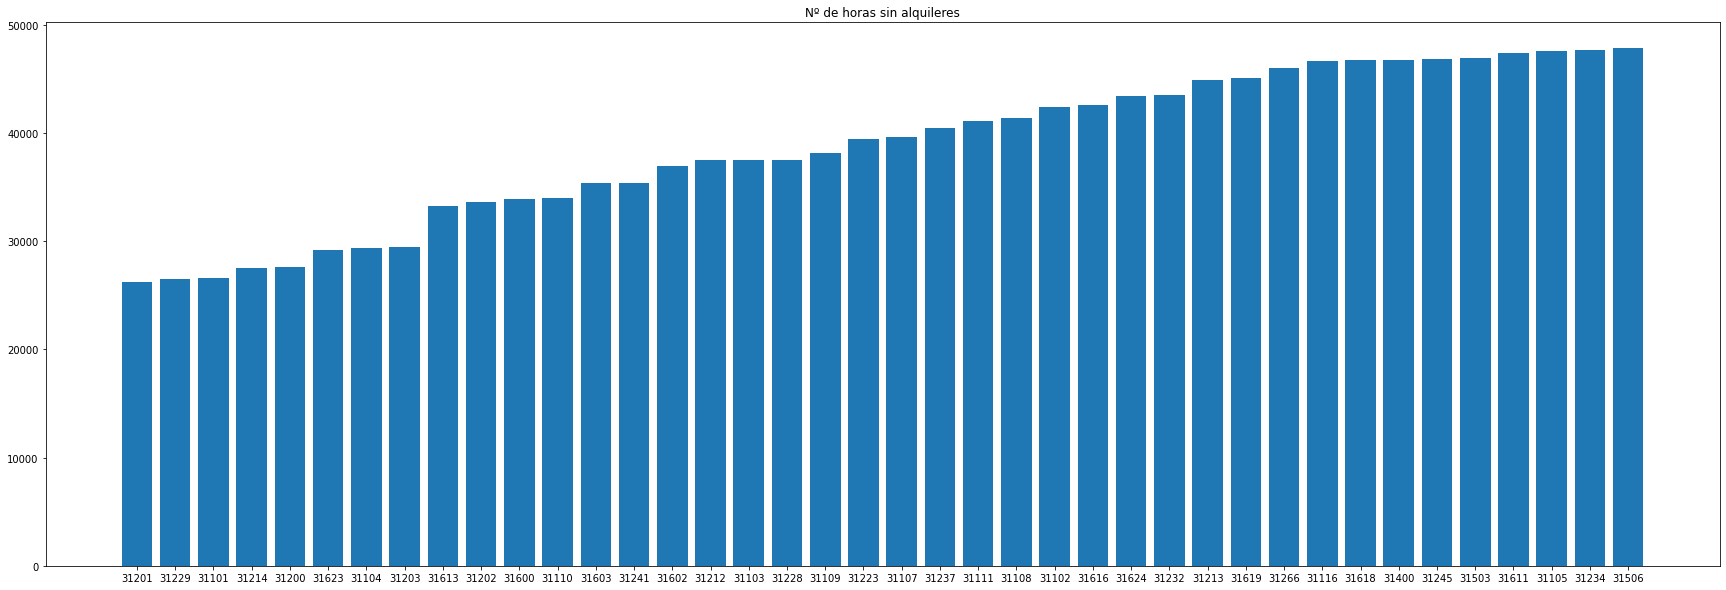

In [63]:
plt.rcParams["figure.figsize"] = (30,10)
plt.bar(*zip(*sortedNullCountRentals[0:40]))
plt.title("Nº de horas sin alquileres")
plt.show()

In [64]:
file = open("../data/completeData/stations/frequentedRentalsStations.txt", "w")
for row in sortedNullCountRentals[0:49]:
    file.write(str(row[0]) + "\n")
file.close()

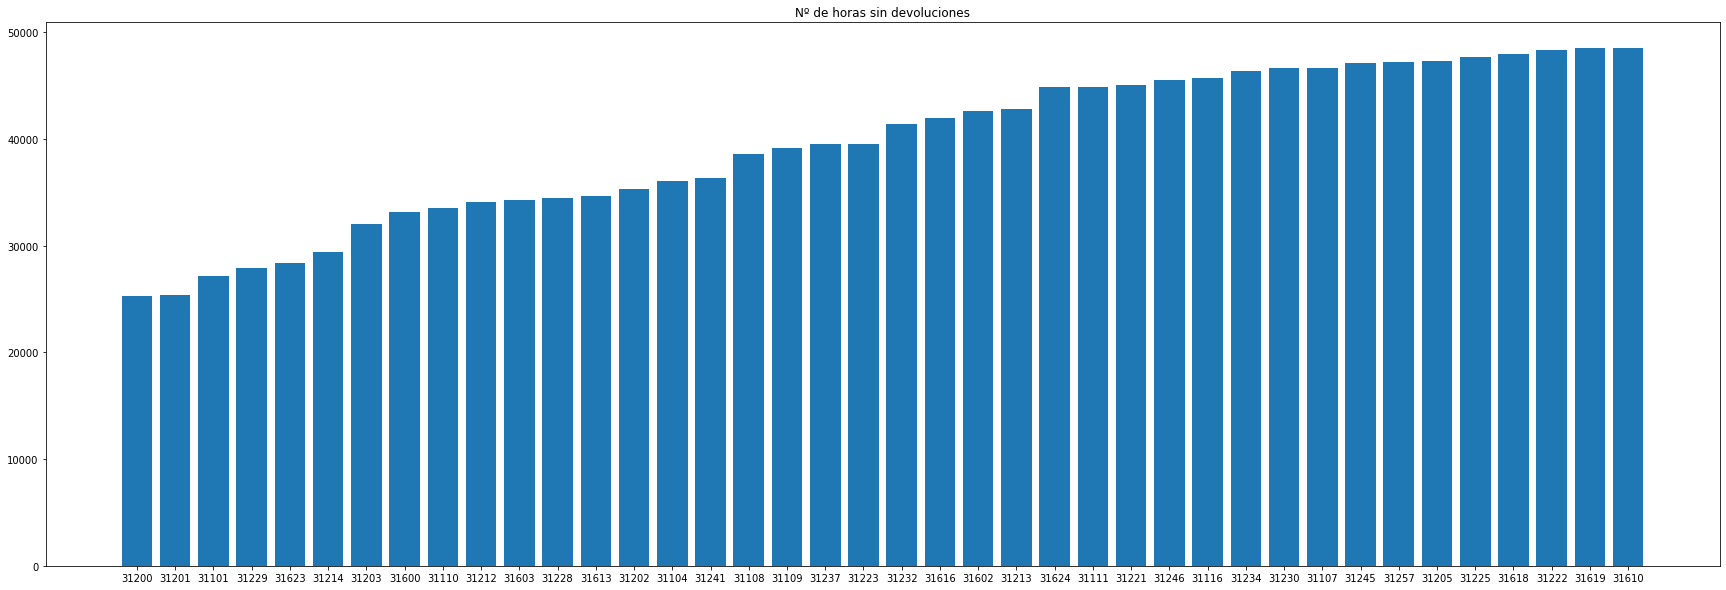

In [65]:
plt.bar(*zip(*sortedNullCountReturns[0:40]))
plt.title("Nº de horas sin devoluciones")
plt.show()

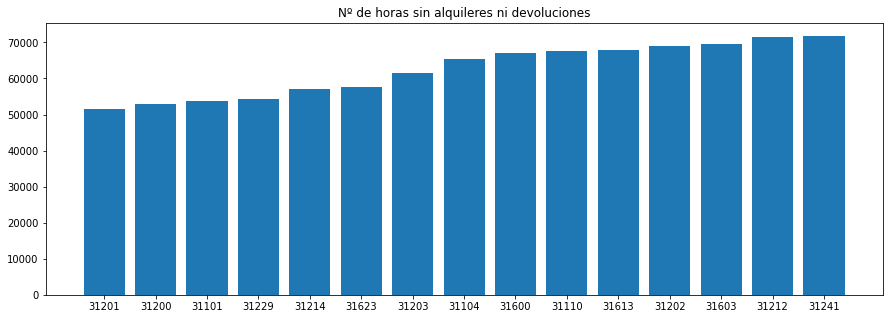

In [80]:
plt.rcParams["figure.figsize"] = (15,5)
plt.bar(*zip(*sortedNullCount[0:15]))
plt.title("Nº de horas sin alquileres ni devoluciones")
plt.show()

In [67]:
file = open("../data/completeData/stations/frequentedStations.txt", "w")
for row in sortedNullCount[0:100]:
    file.write(str(row[0]) + "\n")
file.close()

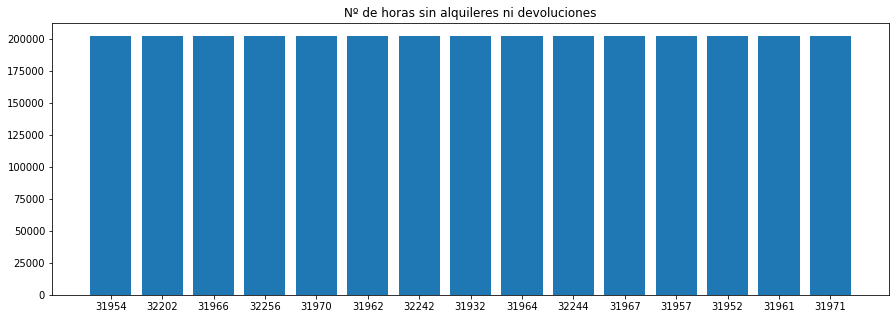

In [87]:
plt.rcParams["figure.figsize"] = (15,5)
len(sortedNullCount)
plt.bar(*zip(*sortedNullCount[679:694]))
plt.title("Nº de horas sin alquileres ni devoluciones")
plt.show()